# Регрессионный подход к оценке ключевых точек рук

В этом ноутбуке мы:
1. Скачаем датасет FreiHAND (evaluation set) с 21 ключевой точкой руки
2. Обучим регрессионную модель на базе ResNet18
3. Оценим качество с помощью метрик PCK и MPJPE
4. Визуализируем предсказания модели


## Импорты


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from PIL import Image
import os
import json
import zipfile
from tqdm import tqdm
import matplotlib.pyplot as plt

torch.manual_seed(42)
np.random.seed(42)
pl.seed_everything(42)


Seed set to 42


42

## Скачивание датасета FreiHAND

FreiHAND — датасет изображений рук с 21 ключевой точкой (wrist + 4 точки на каждый палец).

Используем evaluation set (~3960 изображений, ~660MB).


In [2]:
DATA_DIR = "../data/freihand"
os.makedirs(DATA_DIR, exist_ok=True)

EVAL_ZIP = os.path.join(DATA_DIR, "FreiHAND_pub_v2_eval.zip")
EVAL_DIR = os.path.join(DATA_DIR, "evaluation")


In [3]:
if not os.path.exists(EVAL_DIR):
    print("Скачиваем FreiHAND evaluation set...")
    !wget -q --show-progress -O {EVAL_ZIP} https://lmb.informatik.uni-freiburg.de/data/freihand/FreiHAND_pub_v2_eval.zip
    
    print("Распаковываем архив...")
    with zipfile.ZipFile(EVAL_ZIP, 'r') as zip_ref:
        zip_ref.extractall(DATA_DIR)
    
    os.remove(EVAL_ZIP)
    print("Готово!")
else:
    print(f"Датасет уже существует в {EVAL_DIR}")


Датасет уже существует в ../data/freihand/evaluation


## Загрузка аннотаций

FreiHAND хранит 3D координаты ключевых точек и параметры камеры. Проецируем 3D точки на 2D плоскость изображения.


In [4]:
with open(os.path.join(DATA_DIR, "evaluation_K.json"), "r") as f:
    camera_matrices = json.load(f)

with open(os.path.join(DATA_DIR, "evaluation_xyz.json"), "r") as f:
    xyz_coordinates = json.load(f)

print(f"Количество изображений: {len(camera_matrices)}")
print(f"Количество точек на руке: {len(xyz_coordinates[0])}")


Количество изображений: 3960
Количество точек на руке: 21


In [5]:
def project_3d_to_2d(xyz, K):
    xyz = np.array(xyz)
    K = np.array(K)
    
    uv = np.dot(K, xyz.T).T
    uv = uv[:, :2] / uv[:, 2:]
    
    return uv

keypoints_2d = []
for i in range(len(xyz_coordinates)):
    kp_2d = project_3d_to_2d(xyz_coordinates[i], camera_matrices[i])
    keypoints_2d.append(kp_2d)

keypoints_2d = np.array(keypoints_2d)
print(f"Форма массива keypoints: {keypoints_2d.shape}")


Форма массива keypoints: (3960, 21, 2)


## Визуализация примеров из датасета


In [6]:
SKELETON = [
    [0, 1], [1, 2], [2, 3], [3, 4],
    [0, 5], [5, 6], [6, 7], [7, 8],
    [0, 9], [9, 10], [10, 11], [11, 12],
    [0, 13], [13, 14], [14, 15], [15, 16],
    [0, 17], [17, 18], [18, 19], [19, 20]
]

FINGER_COLORS = {
    'thumb': '#FF6B6B',
    'index': '#4ECDC4',
    'middle': '#45B7D1',
    'ring': '#96CEB4',
    'pinky': '#FFEAA7'
}

def get_edge_color(edge):
    if edge[1] <= 4:
        return FINGER_COLORS['thumb']
    elif edge[1] <= 8:
        return FINGER_COLORS['index']
    elif edge[1] <= 12:
        return FINGER_COLORS['middle']
    elif edge[1] <= 16:
        return FINGER_COLORS['ring']
    else:
        return FINGER_COLORS['pinky']


In [7]:
def visualize_hand(image, keypoints, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    ax.imshow(image)
    
    for edge in SKELETON:
        color = get_edge_color(edge)
        ax.plot(
            [keypoints[edge[0], 0], keypoints[edge[1], 0]],
            [keypoints[edge[0], 1], keypoints[edge[1], 1]],
            color=color, linewidth=2
        )
    
    ax.scatter(keypoints[:, 0], keypoints[:, 1], c='white', s=30, zorder=5, edgecolors='black')
    ax.scatter(keypoints[0, 0], keypoints[0, 1], c='red', s=50, zorder=6, edgecolors='black')
    
    ax.axis('off')
    if title:
        ax.set_title(title)
    
    return ax


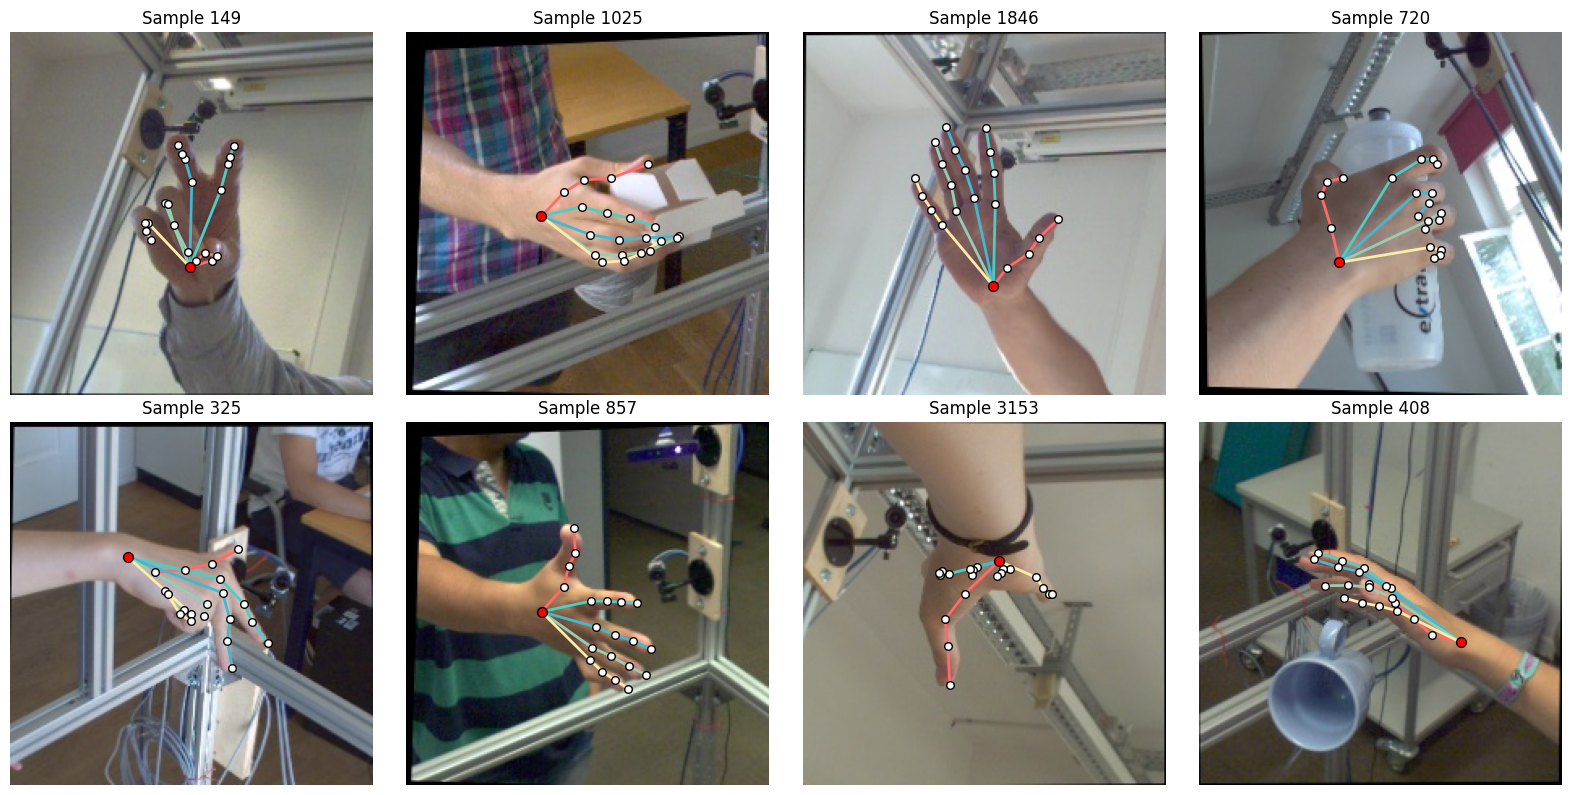

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

indices = np.random.choice(len(keypoints_2d), 8, replace=False)

for i, idx in enumerate(indices):
    img_path = os.path.join(EVAL_DIR, "rgb", f"{idx:08d}.jpg")
    image = Image.open(img_path).convert('RGB')
    image = np.array(image)
    
    visualize_hand(image, keypoints_2d[idx], ax=axes[i], title=f"Sample {idx}")

plt.tight_layout()
plt.show()


## Dataset класс

Нормализуем координаты ключевых точек в диапазон [0, 1] относительно размера изображения.


In [9]:
class FreiHandDataset(Dataset):
    def __init__(self, data_dir, keypoints_2d, indices=None, img_size=224):
        self.data_dir = data_dir
        self.img_size = img_size
        self.indices = indices if indices is not None else list(range(len(keypoints_2d)))
        self.keypoints_2d = keypoints_2d
        self.orig_img_size = 224
        
        self.transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        real_idx = self.indices[idx]
        
        img_path = os.path.join(self.data_dir, "rgb", f"{real_idx:08d}.jpg")
        image = Image.open(img_path).convert('RGB')
        orig_w, orig_h = image.size
        
        image = self.transform(image)
        
        kp = self.keypoints_2d[real_idx].copy()
        kp[:, 0] = kp[:, 0] / orig_w
        kp[:, 1] = kp[:, 1] / orig_h
        kp = np.clip(kp, 0, 1)
        
        keypoints = torch.tensor(kp, dtype=torch.float32).flatten()
        
        return image, keypoints


In [10]:
NUM_SAMPLES = len(keypoints_2d)
indices = np.random.permutation(NUM_SAMPLES)

train_size = int(0.7 * NUM_SAMPLES)
val_size = int(0.15 * NUM_SAMPLES)
test_size = NUM_SAMPLES - train_size - val_size

train_indices = indices[:train_size].tolist()
val_indices = indices[train_size:train_size + val_size].tolist()
test_indices = indices[train_size + val_size:].tolist()

print(f"Train: {len(train_indices)} samples")
print(f"Val: {len(val_indices)} samples")
print(f"Test: {len(test_indices)} samples")


Train: 2772 samples
Val: 594 samples
Test: 594 samples


In [11]:
IMG_SIZE = 224
BATCH_SIZE = 32

train_dataset = FreiHandDataset(EVAL_DIR, keypoints_2d, train_indices, img_size=IMG_SIZE)
val_dataset = FreiHandDataset(EVAL_DIR, keypoints_2d, val_indices, img_size=IMG_SIZE)
test_dataset = FreiHandDataset(EVAL_DIR, keypoints_2d, test_indices, img_size=IMG_SIZE)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)


In [12]:
sample_img, sample_kp = train_dataset[0]
print(f"Image shape: {sample_img.shape}")
print(f"Keypoints shape: {sample_kp.shape}")
print(f"Keypoints range: [{sample_kp.min():.3f}, {sample_kp.max():.3f}]")


Image shape: torch.Size([3, 224, 224])
Keypoints shape: torch.Size([42])
Keypoints range: [0.290, 0.701]


## Модель

Используем ResNet18 с предобученными весами как backbone. Заменяем последний слой на регрессионную голову для предсказания 42 координат (21 точка × 2 координаты).


In [13]:
class KeypointRegressor(nn.Module):
    def __init__(self, num_keypoints=21, pretrained=True):
        super().__init__()
        
        self.backbone = models.resnet18(weights='IMAGENET1K_V1' if pretrained else None)
        
        num_features = self.backbone.fc.in_features
        
        self.backbone.fc = nn.Sequential(
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_keypoints * 2),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.backbone(x)


## PyTorch Lightning модуль

Метрики качества:
- **MPJPE** (Mean Per Joint Position Error) — средняя ошибка в пикселях
- **PCK** (Percentage of Correct Keypoints) — доля точек с ошибкой меньше порога


In [14]:
class KeypointModule(pl.LightningModule):
    def __init__(self, num_keypoints=21, learning_rate=1e-4, img_size=224):
        super().__init__()
        self.save_hyperparameters()
        
        self.model = KeypointRegressor(num_keypoints=num_keypoints)
        self.num_keypoints = num_keypoints
        self.learning_rate = learning_rate
        self.img_size = img_size
    
    def forward(self, x):
        return self.model(x)
    
    def compute_metrics(self, pred, target):
        pred = pred.view(-1, self.num_keypoints, 2) * self.img_size
        target = target.view(-1, self.num_keypoints, 2) * self.img_size
        
        distances = torch.sqrt(((pred - target) ** 2).sum(dim=-1))
        mpjpe = distances.mean()
        
        threshold = 0.05 * self.img_size
        pck = (distances < threshold).float().mean() * 100
        
        return mpjpe, pck
    
    def training_step(self, batch, batch_idx):
        images, keypoints = batch
        pred = self.forward(images)
        
        loss = F.mse_loss(pred, keypoints)
        mpjpe, pck = self.compute_metrics(pred, keypoints)
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True)
        self.log('train_mpjpe', mpjpe, on_step=False, on_epoch=True)
        self.log('train_pck', pck, on_step=False, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):
        images, keypoints = batch
        pred = self.forward(images)
        
        loss = F.mse_loss(pred, keypoints)
        mpjpe, pck = self.compute_metrics(pred, keypoints)
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_mpjpe', mpjpe, on_step=False, on_epoch=True, prog_bar=True)
        self.log('val_pck', pck, on_step=False, on_epoch=True, prog_bar=True)
        
        return loss
    
    def test_step(self, batch, batch_idx):
        images, keypoints = batch
        pred = self.forward(images)
        
        loss = F.mse_loss(pred, keypoints)
        mpjpe, pck = self.compute_metrics(pred, keypoints)
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_mpjpe', mpjpe, on_step=False, on_epoch=True)
        self.log('test_pck', pck, on_step=False, on_epoch=True)
        
        return loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=1e-6)
        return [optimizer], [scheduler]


## Обучение модели


In [15]:
model = KeypointModule(num_keypoints=21, learning_rate=1e-4, img_size=IMG_SIZE)

checkpoint_callback = ModelCheckpoint(
    monitor='val_mpjpe',
    mode='min',
    save_top_k=1,
    filename='hand_keypoints-{epoch:02d}-{val_mpjpe:.2f}'
)

early_stopping = EarlyStopping(
    monitor='val_mpjpe',
    mode='min',
    patience=5
)

trainer = pl.Trainer(
    max_epochs=50,
    accelerator='auto',
    devices=1,
    callbacks=[checkpoint_callback, early_stopping],
    enable_progress_bar=True
)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [16]:
trainer.fit(model, train_loader, val_loader)


You are using a CUDA device ('NVIDIA L40') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | KeypointRegressor | 11.6 M | train
----------------------------------------------------
11.6 M    Trainable params
0         Non-trainable params
11.6 M    Total params
46.325    Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

## Оценка на тестовой выборке


In [17]:
test_results = trainer.test(model, test_loader)
print(f"\nРезультаты на тесте:")
print(f"  MPJPE: {test_results[0]['test_mpjpe']:.2f} px")
print(f"  PCK@5%: {test_results[0]['test_pck']:.1f}%")


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │   0.002123119542375207    │
│        test_mpjpe         │    11.485103607177734     │
│         test_pck          │     60.61408233642578     │
└───────────────────────────┴───────────────────────────┘


Результаты на тесте:
  MPJPE: 11.49 px
  PCK@5%: 60.6%


## Визуализация предсказаний

Сравним ground truth (зелёный) и предсказания модели (красный).


In [18]:
def denormalize_image(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    tensor = tensor * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor.permute(1, 2, 0).numpy()


In [19]:
def visualize_predictions(model, dataset, num_samples=8, img_size=224):
    model.eval()
    device = next(model.parameters()).device
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    with torch.no_grad():
        for i, idx in enumerate(indices):
            image, gt_kp = dataset[idx]
            
            pred_kp = model(image.unsqueeze(0).to(device)).cpu().squeeze()
            
            img_np = denormalize_image(image)
            
            gt_kp = gt_kp.view(21, 2).numpy() * img_size
            pred_kp = pred_kp.view(21, 2).numpy() * img_size
            
            axes[i].imshow(img_np)
            
            for edge in SKELETON:
                axes[i].plot(
                    [gt_kp[edge[0], 0], gt_kp[edge[1], 0]],
                    [gt_kp[edge[0], 1], gt_kp[edge[1], 1]],
                    color='lime', linewidth=2, alpha=0.7
                )
                axes[i].plot(
                    [pred_kp[edge[0], 0], pred_kp[edge[1], 0]],
                    [pred_kp[edge[0], 1], pred_kp[edge[1], 1]],
                    color='red', linewidth=2, alpha=0.7
                )
            
            axes[i].scatter(gt_kp[:, 0], gt_kp[:, 1], c='lime', s=25, zorder=5, edgecolors='black', label='GT')
            axes[i].scatter(pred_kp[:, 0], pred_kp[:, 1], c='red', s=25, zorder=5, edgecolors='black', label='Pred')
            
            error = np.sqrt(((gt_kp - pred_kp) ** 2).sum(axis=1)).mean()
            axes[i].set_title(f'MPJPE: {error:.1f} px')
            axes[i].axis('off')
    
    axes[0].legend(loc='upper left')
    plt.tight_layout()
    plt.show()


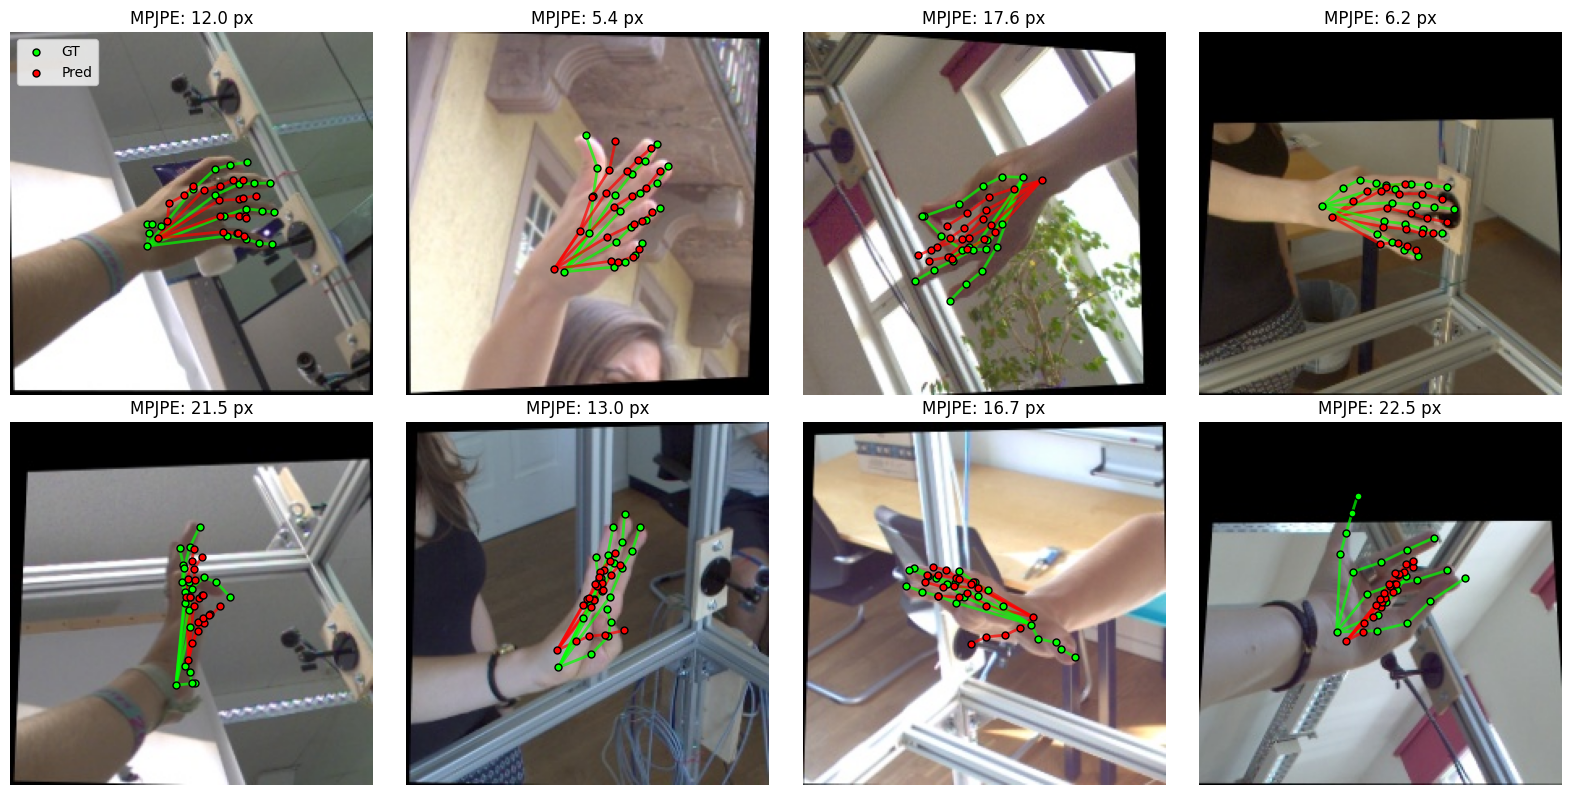

In [20]:
visualize_predictions(model, test_dataset, num_samples=8, img_size=IMG_SIZE)


## Анализ ошибок по точкам

Посмотрим, какие ключевые точки модель предсказывает лучше/хуже.


In [21]:
KEYPOINT_NAMES = [
    'Wrist',
    'Thumb_CMC', 'Thumb_MCP', 'Thumb_IP', 'Thumb_Tip',
    'Index_MCP', 'Index_PIP', 'Index_DIP', 'Index_Tip',
    'Middle_MCP', 'Middle_PIP', 'Middle_DIP', 'Middle_Tip',
    'Ring_MCP', 'Ring_PIP', 'Ring_DIP', 'Ring_Tip',
    'Pinky_MCP', 'Pinky_PIP', 'Pinky_DIP', 'Pinky_Tip'
]


In [22]:
def compute_per_keypoint_error(model, dataloader, img_size=224):
    model.eval()
    device = next(model.parameters()).device
    
    all_errors = []
    
    with torch.no_grad():
        for images, keypoints in tqdm(dataloader, desc="Computing errors"):
            images = images.to(device)
            pred = model(images).cpu()
            
            pred = pred.view(-1, 21, 2) * img_size
            gt = keypoints.view(-1, 21, 2) * img_size
            
            errors = torch.sqrt(((pred - gt) ** 2).sum(dim=-1))
            all_errors.append(errors)
    
    all_errors = torch.cat(all_errors, dim=0)
    return all_errors.mean(dim=0).numpy()


Computing errors: 100%|██████████| 19/19 [00:25<00:00,  1.33s/it]


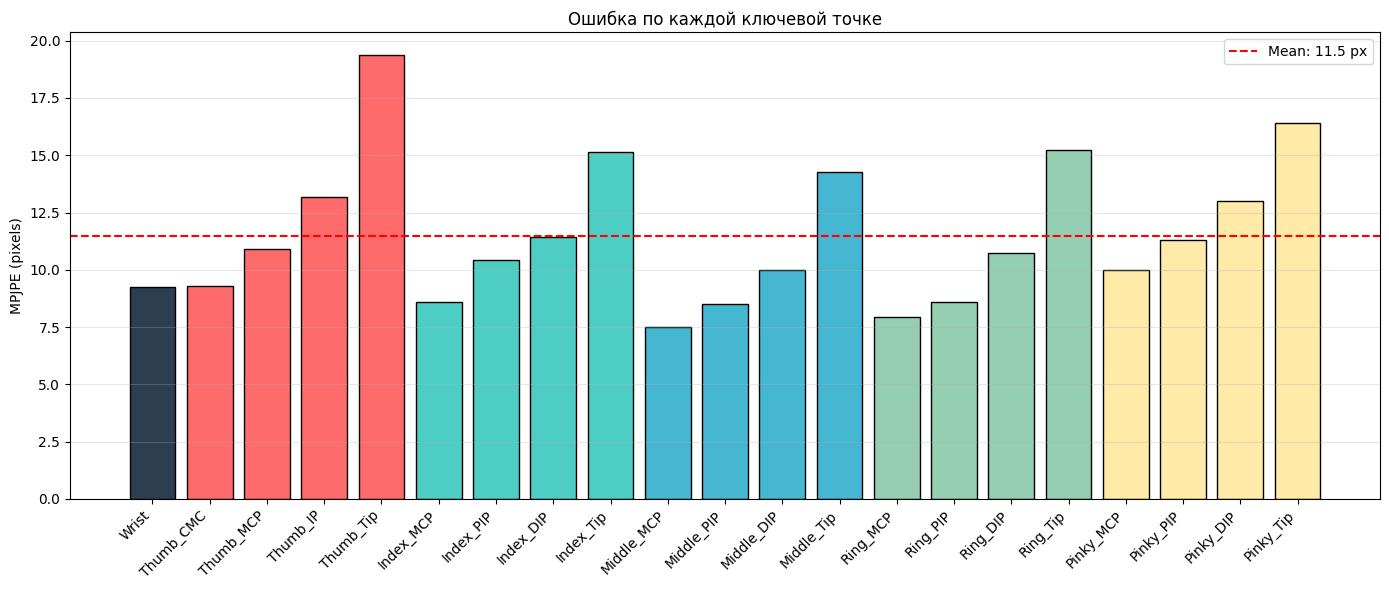

In [23]:
per_kp_errors = compute_per_keypoint_error(model, test_loader, img_size=IMG_SIZE)

fig, ax = plt.subplots(figsize=(14, 6))

colors = ['#2C3E50'] + ['#FF6B6B']*4 + ['#4ECDC4']*4 + ['#45B7D1']*4 + ['#96CEB4']*4 + ['#FFEAA7']*4

bars = ax.bar(range(21), per_kp_errors, color=colors, edgecolor='black')
ax.set_xticks(range(21))
ax.set_xticklabels(KEYPOINT_NAMES, rotation=45, ha='right')
ax.set_ylabel('MPJPE (pixels)')
ax.set_title('Ошибка по каждой ключевой точке')
ax.axhline(y=per_kp_errors.mean(), color='red', linestyle='--', label=f'Mean: {per_kp_errors.mean():.1f} px')
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


## PCK при разных порогах


In [24]:
def compute_pck_curve(model, dataloader, img_size=224, thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0.01, 0.2, 20)
    
    model.eval()
    device = next(model.parameters()).device
    
    all_distances = []
    
    with torch.no_grad():
        for images, keypoints in dataloader:
            images = images.to(device)
            pred = model(images).cpu()
            
            pred = pred.view(-1, 21, 2) * img_size
            gt = keypoints.view(-1, 21, 2) * img_size
            
            distances = torch.sqrt(((pred - gt) ** 2).sum(dim=-1))
            all_distances.append(distances)
    
    all_distances = torch.cat(all_distances, dim=0)
    
    pck_values = []
    for thresh in thresholds:
        threshold_px = thresh * img_size
        pck = (all_distances < threshold_px).float().mean().item() * 100
        pck_values.append(pck)
    
    return thresholds, pck_values


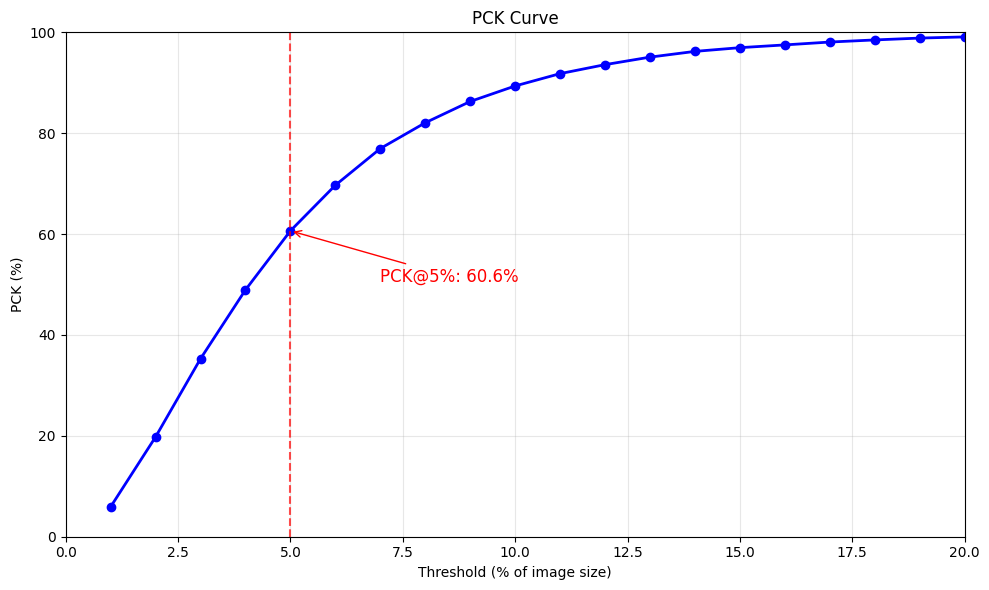

In [25]:
thresholds, pck_values = compute_pck_curve(model, test_loader, img_size=IMG_SIZE)

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(thresholds * 100, pck_values, 'b-o', linewidth=2, markersize=6)
ax.set_xlabel('Threshold (% of image size)')
ax.set_ylabel('PCK (%)')
ax.set_title('PCK Curve')
ax.grid(True, alpha=0.3)
ax.set_xlim([0, 20])
ax.set_ylim([0, 100])

ax.axvline(x=5, color='red', linestyle='--', alpha=0.7)
pck_5 = pck_values[np.argmin(np.abs(thresholds - 0.05))]
ax.annotate(f'PCK@5%: {pck_5:.1f}%', xy=(5, pck_5), xytext=(7, pck_5-10),
            arrowprops=dict(arrowstyle='->', color='red'), fontsize=12, color='red')

plt.tight_layout()
plt.show()
